## Imports and paths

In [5]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



In [16]:
train_dataset_path = '../data/training'
test_dataset_path = '../data/validation'

## Transforming images to tensors and normalazation

In [17]:
mean = [0.5097, 0.5066, 0.4822]
std = [0.2250, 0.2168, 0.2422]
##these calculations are made in a differnt file called mean_std.ipynb it can be done as well but for the sake of     orgenization I seperated them
#(tensor([0.5097, 0.5066, 0.4822]), tensor([0.2250, 0.2168, 0.2422]))

In [18]:
train_transforms = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.RandomRotation(10),
  transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

test_tranforms = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

In [19]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_tranforms)

In [20]:
def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print("labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([2, 3, 6, 3, 1, 6])


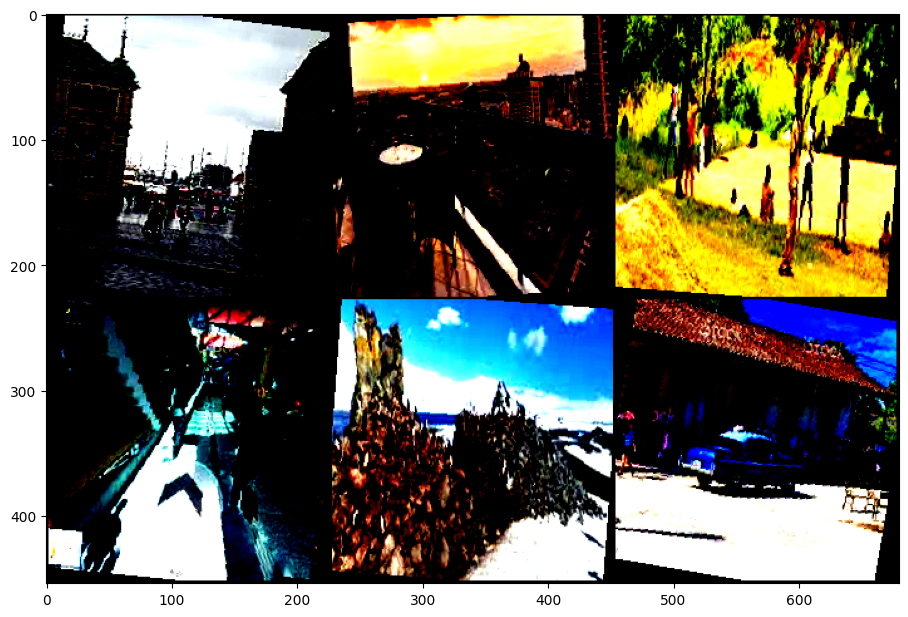

In [21]:
show_transformed_images(train_dataset)

## Train the model

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32 , shuffle=True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32 , shuffle=False )

In [23]:
## if gpu is avaliable it will allow for better run times when training the data set
def set_device():
  if torch.cuda.is_avaliable():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)


In [24]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = "cpu" # if you have cuda use the set_device fn
  best_acc = 0

  for epoch in range(n_epochs):
    print("Epoch number %d" % (epoch + 1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100 * running_correct/ total

    print("     -Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))  

    
  test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

  if(test_dataset_acc > best_acc):
    best_acc = test_dataset_acc
    save_checkpoint(model, epoch, optimizer, best_acc)
  
  print("Finished")
  return model

In [25]:
def evaluate_model_on_test_set(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = "cpu"

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      predicted_correctly_on_epoch += (predicted == labels).sum().item()
  
  epoch_acc = 100*predicted_correctly_on_epoch/total
  print("     -Testing dataset. got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))
  return epoch_acc


In [26]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
    'epoch': epoch+1,
    'model': model.state_dict(),
    'best accuracy': best_acc,
    'optimizer' : optimizer.state_dict()   
  }
  torch.save(state, 'model_best_checkpoint.pth.tar')

In [27]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
resnet50_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = resnet50_model.fc.in_features
number_of_classes = 7
resnet50_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet_50_model = resnet50_model.to("cpu") ## set a device = set_device() and use it instead of cpu
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet50_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [28]:
train_nn(resnet50_model, train_loader, test_loader, loss_fn, optimizer, 22)

Epoch number 1
     -Training Dataset. Got 1097 out of 2578 images correctly (42.552%). Epoch Loss: 1.487
Epoch number 2
     -Training Dataset. Got 1588 out of 2578 images correctly (61.598%). Epoch Loss: 1.060
Epoch number 3
     -Training Dataset. Got 1902 out of 2578 images correctly (73.778%). Epoch Loss: 0.737
Epoch number 4
     -Training Dataset. Got 2191 out of 2578 images correctly (84.988%). Epoch Loss: 0.461
Epoch number 5
     -Training Dataset. Got 2294 out of 2578 images correctly (88.984%). Epoch Loss: 0.335
Epoch number 6
     -Training Dataset. Got 2360 out of 2578 images correctly (91.544%). Epoch Loss: 0.257
Epoch number 7
     -Training Dataset. Got 2331 out of 2578 images correctly (90.419%). Epoch Loss: 0.278
Epoch number 8
     -Training Dataset. Got 2333 out of 2578 images correctly (90.497%). Epoch Loss: 0.258
Epoch number 9
     -Training Dataset. Got 2439 out of 2578 images correctly (94.608%). Epoch Loss: 0.171
Epoch number 10
     -Training Dataset. Got 24

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

NameError: name 'torch' is not defined

In [30]:
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
print(checkpoint['model'])


22
63.37837837837838
OrderedDict([('conv1.weight', tensor([[[[-3.6793e-02, -2.2022e-02,  1.2798e-02,  ...,  3.3035e-02,
           -7.1645e-03,  4.9819e-03],
          [-6.8561e-02,  8.7820e-04,  4.1362e-02,  ...,  4.5895e-02,
            1.2173e-02, -4.1909e-02],
          [ 1.2843e-02, -1.8531e-01,  2.2847e-01,  ..., -1.0841e-01,
            1.1339e-01, -5.8577e-02],
          ...,
          [-7.8393e-02,  2.2199e-01, -2.8386e-01,  ...,  3.9488e-01,
           -3.4942e-01,  1.2178e-01],
          [-2.1699e-04, -1.0730e-01,  3.7213e-01,  ...,  3.0056e-01,
           -4.2152e-02, -4.5103e-02],
          [ 1.6085e-02, -7.7666e-02,  9.4929e-03,  ..., -2.2118e-01,
            1.0070e-01, -1.8655e-02]],

         [[-1.1351e-02, -4.2135e-04, -5.7708e-03,  ...,  6.1068e-02,
           -2.8530e-02,  1.3072e-02],
          [-4.4057e-02,  1.0111e-02,  5.8924e-02,  ...,  7.1311e-02,
            1.3892e-02, -3.1358e-02],
          [ 1.3626e-02, -1.7011e-01,  2.5400e-01,  ..., -1.4144e-01,
       

In [1]:
resnet50_model = models.resnet50()
num_ftrs = resnet50_model.fc.in_features
number_of_classes = 7
resnet50_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet50_model.load_state_dict(checkpoint['model'])

torch.save(resnet50_model, 'best_model.pth')

NameError: name 'models' is not defined